<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3_ModelFitting/W1D3_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 3, Tutorial 4
# Model Fitting: Multiple linear regression and polynomial regression

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Byron Galbraith, Ella Batty

**Content reviewers**: Lina Teichmann, Saeed Salehi, Patrick Mineault, Michael Waskom

---
#Tutorial Objectives

This is Tutorial 4 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

In this tutorial, we will generalize the regression model to incorporate multiple features.
- Learn how to structure inputs for regression using the 'Design Matrix'
- Generalize the MSE for multiple features using the ordinary least squares estimator
- Visualize data and model fit in multiple dimensions
- Fit polynomial regression models of different complexity
- Plot and evaluate the polynomial regression fits


Video available at https://youtube.com/watch?v=d4nfTki6Ejc


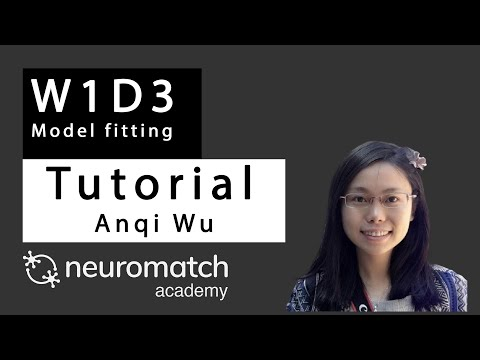

In [1]:
#@title Video 1: Multiple Linear Regression and Polynomial Regression
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="d4nfTki6Ejc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Helper Functions

def plot_fitted_polynomials(x, y, theta_hat):
  """ Plot polynomials of different orders

  Args:
    x (ndarray): input vector of shape (n_samples) 
    y (ndarray): vector of measurements of shape (n_samples)
    theta_hat (dict): polynomial regression weights for different orders
  """

  x_grid = np.linspace(x.min() - .5, x.max() + .5)

  plt.figure()

  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x_grid, order)
    plt.plot(x_grid, X_design @ theta_hat[order]);

  plt.ylabel('y')
  plt.xlabel('x')
  plt.plot(x, y, 'C0.');
  plt.legend([f'order {o}' for o in range(max_order + 1)], loc=1)
  plt.title('polynomial fits')
  plt.show()


---
# Section 1: Multiple Linear Regression


Now that we have considered the univariate case and how to produce confidence intervals for our estimator, we turn to the general linear regression case, where we can have more than one regressor, or feature, in our input.

Recall that our original univariate linear model was given as

\begin{align}
y = \theta x + \epsilon
\end{align}

where $\theta$ is the slope and $\epsilon$ some noise. We can easily extend this to the multivariate scenario by adding another parameter for each additional feature

\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + ... +\theta_d x_d + \epsilon
\end{align}

where $\theta_0$ is the intercept and $d$ is the number of features (it is also the dimensionality of our input).

We can condense this succinctly using vector notation for a single data point

\begin{align}
y_i = \boldsymbol{\theta}^{\top}\mathbf{x}_i + \epsilon
\end{align}

and fully in matrix form

\begin{align}
\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \mathbf{\epsilon}
\end{align}

where $\mathbf{y}$ is a vector of measurements, $\mathbf{X}$ is a matrix containing the feature values (columns) for each input sample (rows), and $\boldsymbol{\theta}$ is our parameter vector.

This matrix $\mathbf{X}$ is often referred to as the "[design matrix](https://en.wikipedia.org/wiki/Design_matrix)".

For this tutorial we will focus on the two-dimensional case ($d=2$), which allows us to easily visualize our results. As an example, think of a situation where a scientist records the spiking response of a retinal ganglion cell to patterns of light signals that vary in contrast and in orientation. Then contrast and orientation values can be used as features / regressors to predict the cells response.

In this case our model can be writen as:

\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \epsilon
\end{align}

or in matrix form where

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2} \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}, 
\boldsymbol{\theta} =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\end{bmatrix}
\end{align}

For our actual exploration dataset we shall set $\boldsymbol{\theta}=[0, -2, -3]$ and draw $N=40$ noisy samples from $x \in [-2,2)$. Note that setting the value of $\theta_0 = 0$ effectively ignores the offset term.

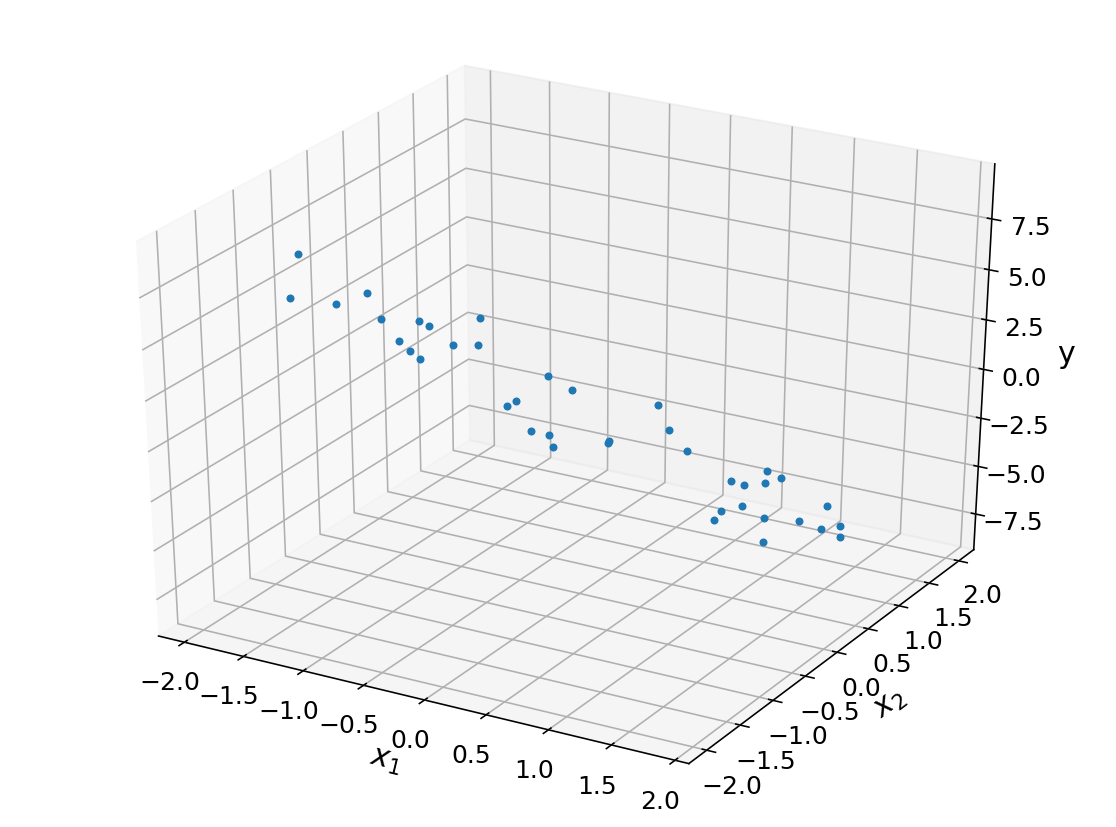

In [5]:
#@title
#@markdown Execute this cell to simulate some data

# Set random seed for reproducibility
np.random.seed(1234)

# Set parameters
theta = [0, -2, -3]
n_samples = 40

# Draw x and calculate y
n_regressors = len(theta)
x0 = np.ones((n_samples, 1)) 
x1 = np.random.uniform(-2, 2, (n_samples, 1))
x2 = np.random.uniform(-2, 2, (n_samples, 1))
X = np.hstack((x0, x1, x2))
noise = np.random.randn(n_samples)
y = X @ theta + noise


ax = plt.subplot(projection='3d')
ax.plot(X[:,1], X[:,2], y, '.')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()


Now that we have our dataset, we want to find an optimal vector of paramters $\boldsymbol{\hat\theta}$. Recall our analytic solution to minimizing MSE for a single regressor:

\begin{align}
\hat\theta = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}.
\end{align}

The same holds true for the multiple regressor case, only now expressed in matrix form

\begin{align}
\boldsymbol{\hat\theta} = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}.
\end{align}

This is called the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) estimator.

### Exercise 1: Ordinary Least Squares Estimator

In this exercise you will implement the OLS approach to estimating $\boldsymbol{\hat\theta}$ from the design matrix $\mathbf{X}$ and measurement vector $\mathbf{y}$. You can use the `@` symbol for matrix multiplication, `.T` for transpose, and `np.linalg.inv` for matrix inversion.


In [6]:
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  # Fill out function and remove
  raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
  ######################################################################
  
  # Compute theta_hat using OLS
  theta_hat = ...

  return theta_hat


# Uncomment below to test your function
# theta_hat = ordinary_least_squares(X, y)
# print(theta_hat)

In [7]:
# to_remove solution
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    X (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  
  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
  
  return theta_hat


theta_hat = ordinary_least_squares(X, y)
print(theta_hat)

[ 0.13861386 -2.09395731 -3.16370742]


After filling in this function, you should see that $\hat{\theta}$ = [ 0.13861386, -2.09395731, -3.16370742]

Now that we have our $\mathbf{\hat\theta}$, we can obtain $\mathbf{\hat y}$ and thus our mean squared error.

In [8]:
# Compute predicted data
theta_hat = ordinary_least_squares(X, y)
y_hat = X @ theta_hat

# Compute MSE
print(f"MSE = {np.mean((y - y_hat)**2):.2f}")

MSE = 0.91


Finally, the following code will plot a geometric visualization of the data points (blue) and fitted plane. You can see that the residuals (green bars) are orthogonal to the plane.

Extra: how would you check that the residuals are orthogonal to the fitted plane? (this is sometimes called the orthogonality principle, see [least squares notes](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf))

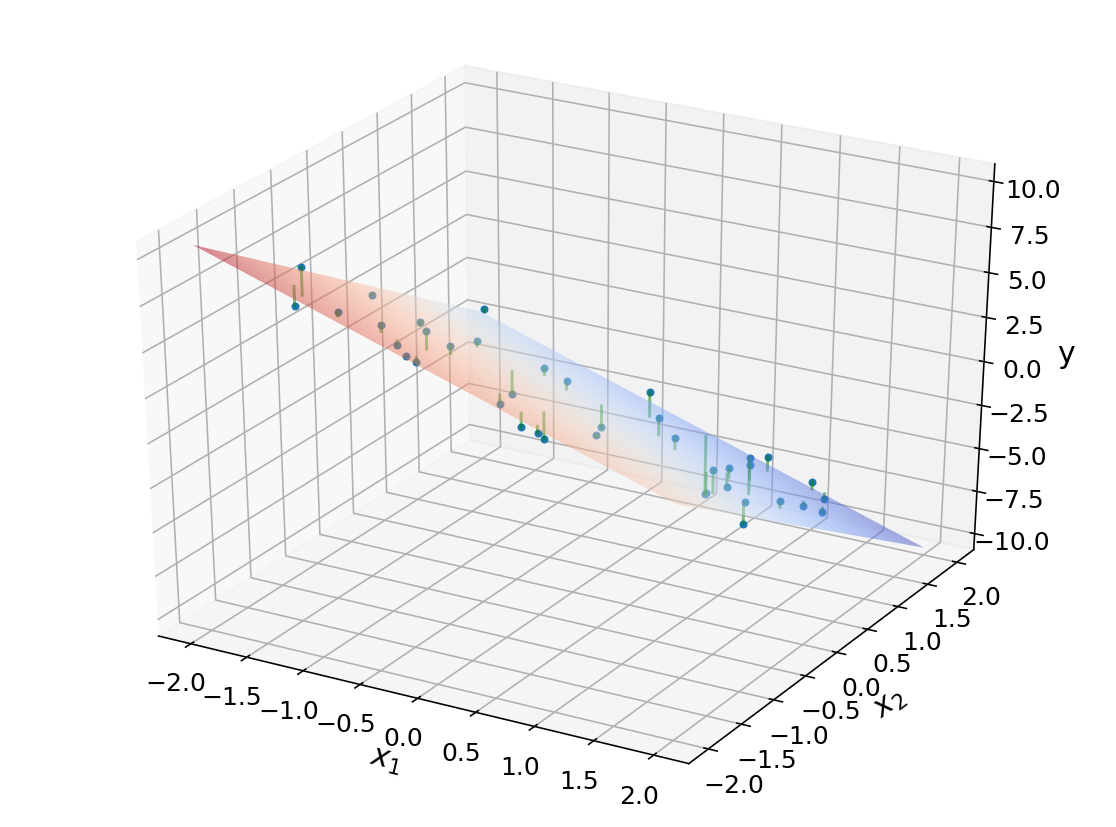

In [9]:
#@title
#@markdown Execute this cell to visualize data and predicted plane

theta_hat = ordinary_least_squares(X, y)
xx, yy = np.mgrid[-2:2:50j, -2:2:50j]
y_hat_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_hat[1:]
y_hat_grid = y_hat_grid.reshape((50, 50))

ax = plt.subplot(projection='3d')
ax.plot(X[:, 1], X[:, 2], y, '.')
ax.plot_surface(xx, yy, y_hat_grid, linewidth=0, alpha=0.5, color='C1',
                cmap=plt.get_cmap('coolwarm'))

for i in range(len(X)):
  ax.plot((X[i, 1], X[i, 1]),
          (X[i, 2], X[i, 2]),
          (y[i], y_hat[i]),
          'g-', alpha=.5)

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()


---
# Section 2:  Polynomial Regression

So far today, you learned how to predict outputs from inputs by fitting a linear regression model. We can now model all sort of relationships, including in neuroscience!  

One potential problem with this approach is the simplicity of the model. Linear regression, as the name implies, can only capture a linear relationship between the inputs and outputs. Put another way, the predicted outputs are only a weighted sum of the inputs. What if there are more complicated computations happening? Luckily, many more complex models exist (and you will encounter many more over the next 3 weeks). One model that is still very simple to fit and understand, but captures more complex relationships, is **polynomial regression**, an extension of linear regression.

Since polynomial regression is an extension of linear regression, everything you learned so far will come in handy now! The goal is the same: we want to predict the dependent variable $y_{n}$ given the input values $x_{n}$. The key change is the type of relationship between inputs and outputs that the model can capture. 

Linear regression models predict the outputs as a weighted sum of the inputs:

$$y_{n}= \theta_0 + \theta x_{n} + \epsilon_{n}$$

With polynomial regression, we model the outputs as a polynomial equation based on the inputs. For example, we can model the outputs as:

$$y_{n}= \theta_0 + \theta_1 x_{n} + \theta_2 x_{n}^2 + \theta_3 x_{n}^3 + \epsilon_{n}$$

We can change how complex a polynomial is fit by changing the order of the polynomial. The order of a polynomial refers to the highest power in the polynomial. The equation above is a third order polynomial because the highest value x is raised to is 3. We could add another term ($+ \theta_4 x_{n}^4$) to model an order 4 polynomial and so on.



First, we will simulate some data to practice fitting polynomial regression models. We will generate random inputs $x$ and then compute y according to $y = x^2 - x - 2 $, with some extra noise both in the input and the output to make the model fitting exercise closer to a real life situation.

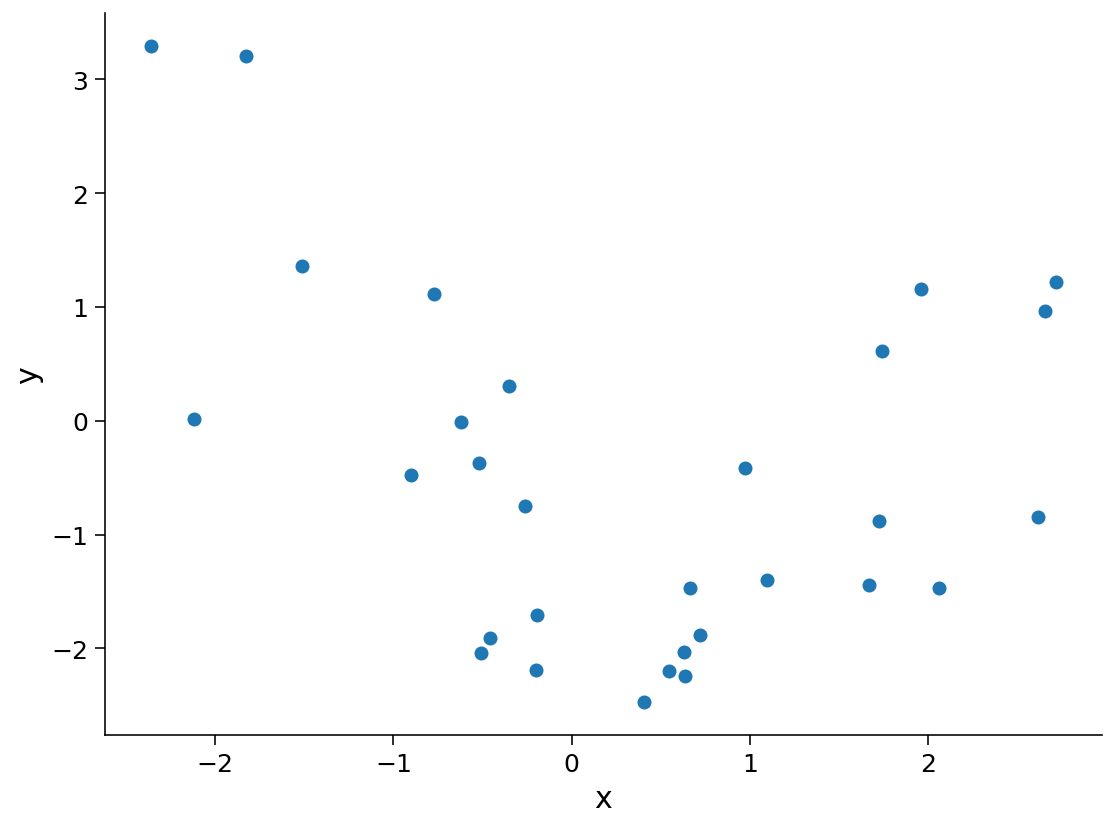

In [10]:
#@title
#@markdown Execute this cell to simulate some data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)
n_samples = 30
x = np.random.uniform(-2, 2.5, n_samples)  # inputs uniformly sampled from [-2, 2.5)
y =  x**2 - x - 2   # computing the outputs

output_noise = 1/8 * np.random.randn(n_samples)
y += output_noise  # adding some output noise

input_noise = 1/2 * np.random.randn(n_samples)
x += input_noise  # adding some input noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y'); 

## Section 2.1: Design matrix for polynomial regression

Now we have the basic idea of polynomial regression and some noisy data, let's begin! The key difference between fitting a linear regression model and a polynomial regression model lies in how we structure the input variables.  

For linear regression, we used $X = x$ as the input data. To add a constant bias (a y-intercept in a 2-D plot), we use $X = \big[ \boldsymbol 1, x \big]$, where $\boldsymbol 1$ is a column of ones.  When fitting, we learn a weight for each column of this matrix. So we learn a weight that multiples with column 1 - in this case that column is all ones so we gain the bias parameter ($+ \theta_0$). We also learn a weight for every column, or every feature of x, as we learned in Section 1.

This matrix $X$ that we use for our inputs is known as a **design matrix**. We want to create our design matrix so we learn weights for $x^2, x^3,$ etc. Thus, we want to build our design matrix $X$ for polynomial regression of order $k$ as:

$$X = \big[ \boldsymbol 1 , x^1, x^2 , \ldots , x^k \big],$$

where $\boldsymbol{1}$ is the vector the same length as $x$ consisting of of all ones, and $x^p$ is the vector or matrix $x$ with all elements raised to the power $p$. Note that $\boldsymbol{1} = x^0$ and $x^1 = x$ 

### Exercise 2: Structure design matrix

Create a function (`make_design_matrix`) that structures the design matrix given the input data and the order of the polynomial you wish to fit. We will print part of this design matrix for our data and order 5.

In [11]:
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  
  Args:
    x (ndarray): input vector of shape (n_samples) 
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """
  ########################################################################
  ## TODO for students: create the design matrix ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: create the design matrix")
  ########################################################################

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1)) 

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = ...

  return design_matrix


# Uncomment to test your function
order = 5
# X_design = make_design_matrix(x, order)
# print(X_design[0:2, 0:2])

In [12]:
# to_remove solution
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  
  Args:
    x (ndarray): input vector of shape (samples,) 
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1) so dimensions work 
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1)) 

  # Loop through rest of degrees and stack columns
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix
  
  
order = 5
X_design = make_design_matrix(x, order)
print(X_design[0:2, 0:2])

[[ 1.         -1.51194917]
 [ 1.         -0.35259945]]


You should see that the printed section of this design matrix is `[[ 1.         -1.51194917]
 [ 1.         -0.35259945]]`

## Section 2.2: Fitting polynomial regression models

Now that we have the inputs structured correctly in our design matrix, fitting a polynomial regression is the same as fitting a linear regression model! All of the polynomial structure we need to learn is contained in how the inputs are structured in the design matrix. We can use the same least squares solution we computed in previous exercises. 

### Exercise 3: Fitting polynomial regression models with different orders 

Here, we will fit polynomial regression models to find the regression coefficients ($\theta_0, \theta_1, \theta_2,$ ...) by solving the least squares problem. Create a function `solve_poly_reg` that loops over different order polynomials (up to `max_order`), fits that model, and saves out the weights for each. You may invoke the `ordinary_least_squares` function. 

We will then qualitatively inspect the quality of our fits for each order by plotting the fitted polynomials on top of the data. In order to see smooth curves, we evaluate the fitted polynomials on a grid of $x$ values (ranging between the largest and smallest of the inputs present in the dataset).

In [13]:
def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  
  Args:
    x (ndarray): input vector of shape (n_samples) 
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta_hat 
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    ##################################################################################
    ## TODO for students: Create design matrix and fit polynomial model for this order 
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fit a polynomial model")
    ##################################################################################
    
    # Create design matrix
    X_design = ...

    # Fit polynomial model
    this_theta = ...

    theta_hats[order] = this_theta

  return theta_hats


# Uncomment to test your function
max_order = 5
#theta_hats = solve_poly_reg(x, y, max_order)
#plot_fitted_polynomials(x, y, theta_hats)


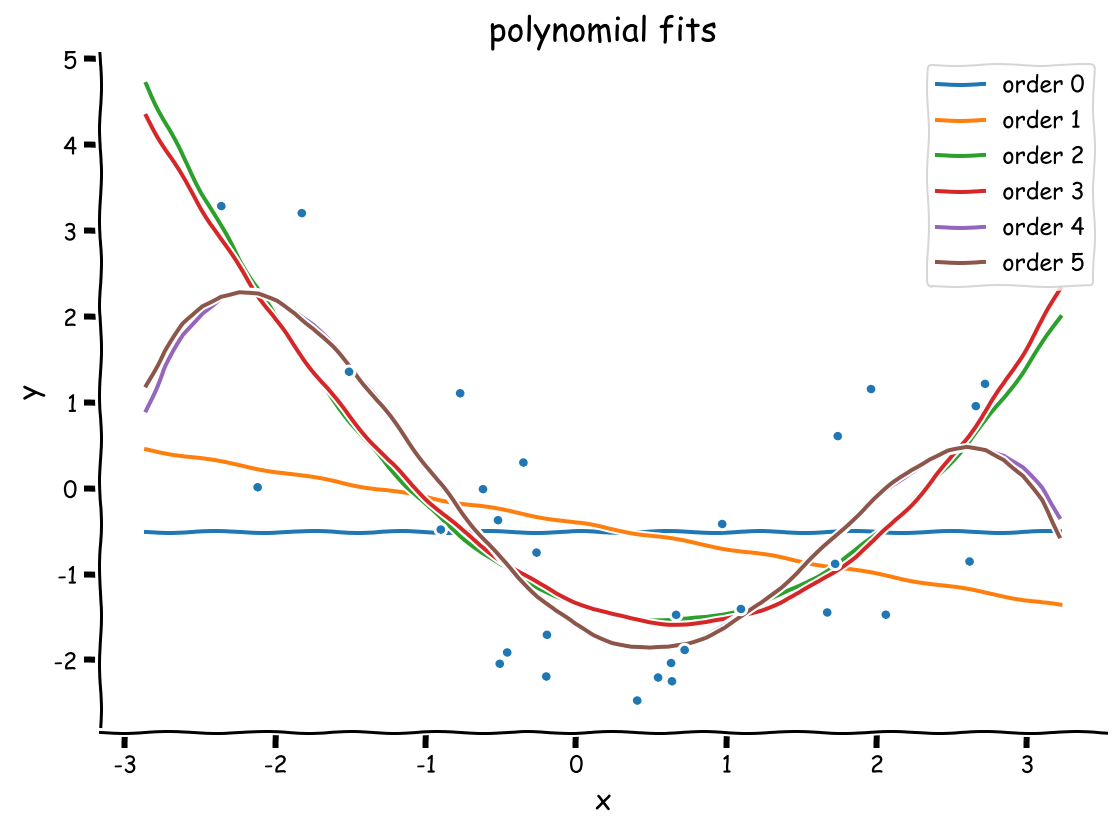

In [14]:
# to_remove solution

def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  
  Args:
    x (ndarray): input vector of shape (n_samples) 
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta 
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    X_design = make_design_matrix(x, order)
    
    this_theta = ordinary_least_squares(X_design, y)

    theta_hats[order] = this_theta

  return theta_hats


max_order = 5
theta_hats = solve_poly_reg(x, y, max_order)
with plt.xkcd():
  plot_fitted_polynomials(x, y, theta_hats)


## Section 2.4: Evaluating fit quality

As with linear regression, we can compute mean squared error (MSE) to get a sense of how well the model fits the data. 

We compute MSE as:

$$ MSE = \frac 1 N ||y - \hat y||^2 = \sum_{i=1}^N (y_i - \hat y_i)^2 $$

where the predicted values for each model are given by $ \hat y = X \hat \theta$. 

*Which model (i.e. which polynomial order) do you think will have the best MSE?*

### Exercise 4: Compute MSE and compare models

We will compare the MSE for different polynomial orders with a bar plot.

[Text(0, 0.5, 'MSE'),
 Text(0.5, 0, 'Polynomial order'),
 Text(0.5, 1.0, 'Comparing Polynomial Fits')]

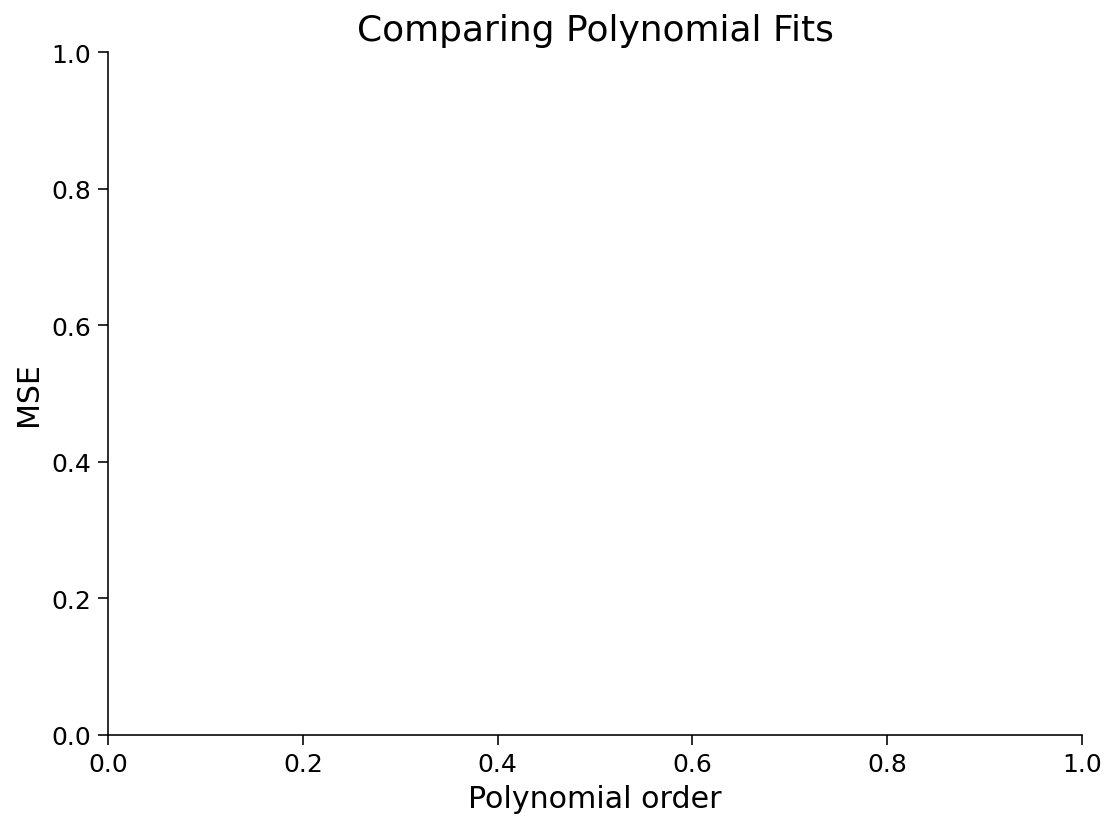

In [15]:
mse = np.zeros((max_order + 1))
for order in range(0, max_order + 1):
  
  X_design = make_design_matrix(x, order)

  ############################################################################
  ## TODO for students: Compute MSE
  #############################################################################

  ## Uncomment below and fill in with your code

  # Get prediction for the polynomial regression model of this order
  #y_hat = ...

  # Compute the residuals
  #residuals = ...

  # Compute the MSE
  #mse[order] = ...
  
  pass

fig, ax = plt.subplots()

# Uncomment once above exercise is complete
#   ax.bar(range(max_order + 1), mse);

ax.set(title='Comparing Polynomial Fits', xlabel='Polynomial order', ylabel='MSE')

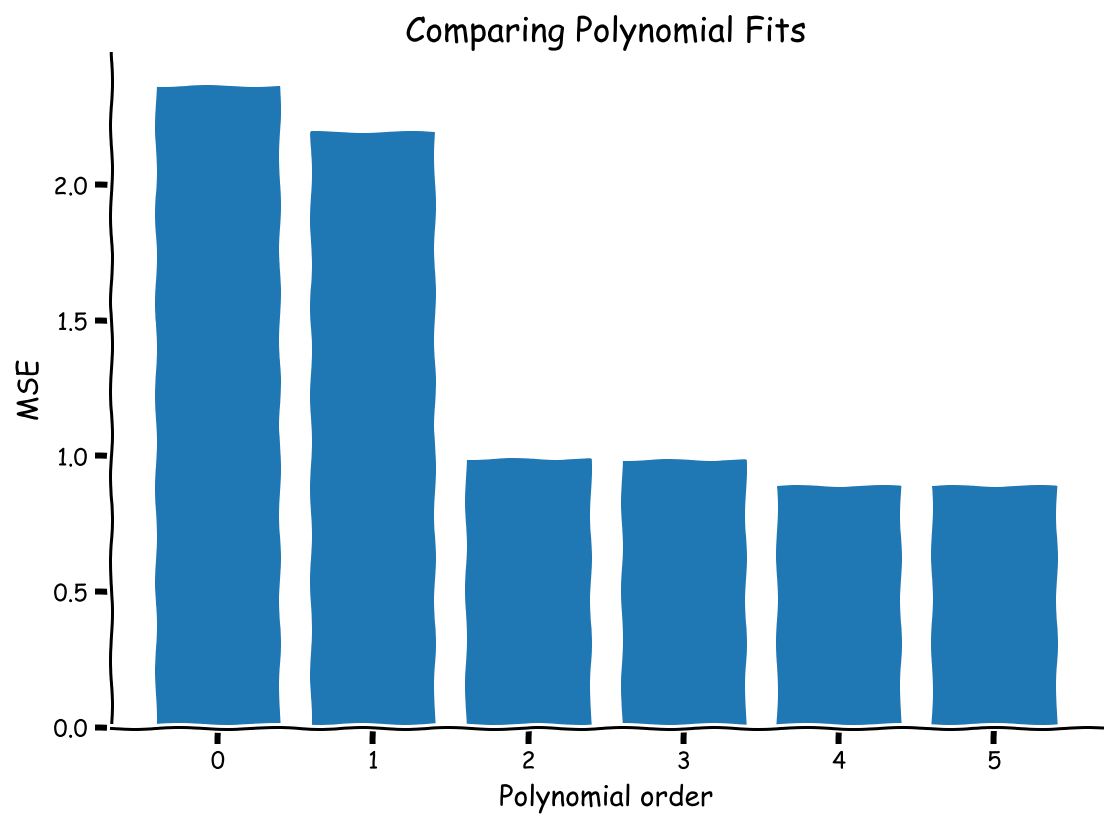

In [16]:
# to_remove solution
mse = np.zeros((max_order + 1))
for order in range(0, max_order + 1):

  X_design = make_design_matrix(x, order)

  # Get prediction for the polynomial regression model of this order
  y_hat = X_design @ theta_hats[order]

  # Compute the residuals
  residuals = y - y_hat

  # Compute the MSE
  mse[order] = np.mean(residuals ** 2)

with plt.xkcd():
  fig, ax = plt.subplots()

  ax.bar(range(max_order + 1), mse);

  ax.set(title='Comparing Polynomial Fits', xlabel='Polynomial order', ylabel='MSE')

---
# Summary

* Linear regression generalizes naturally to multiple dimensions
* Linear algebra affords us the mathematical tools to reason and solve such problems beyond the two dimensional case

* To change from a linear regression model to a polynomial regression model, we only have to change how the input data is structured

* We can choose the complexity of the model by changing the order of the polynomial model fit

* Higher order polynomial models tend to have lower MSE on the data they're fit with

**Note**: In practice, multidimensional least squares problems can be solved very efficiently (thanks to numerical routines such as LAPACK).



**Suggested readings**  

[Introduction to Applied Linear Algebra – Vectors, Matrices, and Least Squares](http://vmls-book.stanford.edu/)
Stephen Boyd and Lieven Vandenberghe